In [52]:
import numpy as np
from sklearn.datasets import fetch_openml
import matplotlib.pyplot as plt

In [77]:
input_size = 28*28
hidden_size = 16
output_size = 10
learning_rate = 0.1

X, y = fetch_openml('mnist_784', version=1, return_X_y=True)
X = np.array(X) / 255.0
y = np.array(y).astype(int)

layer_count = 2

W = {
    1: {
        "W": np.random.randn(hidden_size, input_size) * 0.01,
        "b": np.zeros((hidden_size, 1))
    },
    2: {
        "W": np.random.randn(output_size, hidden_size) * 0.01,
        "b": np.zeros((output_size, 1))
    }
}

In [78]:
def ReLU(x):
    return np.maximum(0, x)

def dReLU(x):
    return x > 0

def softmax(z):
    exp_z = np.exp(z - np.max(z))
    return exp_z / np.sum(exp_z)

def feedForward(PastLayer, LayerCount, cache=None):
    if cache is None:
        cache = {}
    if LayerCount > layer_count:
        return PastLayer, cache
    else:
        Z = W[LayerCount]["W"] @ PastLayer + W[LayerCount]["b"]
        if LayerCount == layer_count:
            A = softmax(Z)
        else:
            A = ReLU(Z)
        cache[LayerCount] = {"Z": Z, "A": A}
        return feedForward(A, LayerCount + 1, cache)


def calculateError(ExpectedOutput, ActualOutput):
    diff = ExpectedOutput - ActualOutput
    return np.sum(diff ** 2)

In [79]:
def backPropagation(x, y_true, cache, learning_rate):
    # x: input vector (shape: input_size x 1)
    # y_true: one-hot vector (10 x 1)
    # cache: dictionar cu Z si A pe fiecare layer
    # learning_rate: baza de invatare

    grads = {}
    m = 1  # batch size (1 pentru exemplul acesta)

    # 1) Calculam eroarea la output (layer 2)
    A2 = cache[2]["A"]  # output-ul softmax (10x1)
    dZ2 = A2 - y_true   # derivata functiei cost cross-entropy + softmax: simplifica la A - y_true

    # Gradientii pentru layer 2
    A1 = cache[1]["A"]  # activarea layerului 1 (128x1)
    dW2 = (dZ2 @ A1.T) / m  # (10x1)@(1x128) = 10x128
    db2 = dZ2 / m           # 10x1

    # 2) Calculam eroarea pentru layer 1
    W2 = W[2]["W"]         # 10x128
    dA1 = W2.T @ dZ2       # (128x10)@(10x1) = 128x1
    Z1 = cache[1]["Z"]
    dZ1 = dA1 * dReLU(Z1)  # element-wise multiplicare cu derivata ReLU (128x1)

    # Gradientii pentru layer 1
    x = x.reshape(-1,1)    # 784x1
    dW1 = (dZ1 @ x.T) / m  # (128x1)@(1x784) = 128x784
    db1 = dZ1 / m          # 128x1

    # 3) Adaptam learning rate proportional cu inversa normei gradientului (simplu)
    # Calculam norma totala a gradientilor
    grad_norm = np.linalg.norm(dW1) + np.linalg.norm(dW2)
    adaptive_lr = learning_rate / (grad_norm + 1e-8)  # +eps pentru stabilitate

    # 4) Actualizam weight-urile si bias-urile
    W[1]["W"] -= adaptive_lr * dW1
    W[1]["b"] -= adaptive_lr * db1
    W[2]["W"] -= adaptive_lr * dW2
    W[2]["b"] -= adaptive_lr * db2


In [80]:
errors = []
steps = []

for i in range(65000):
    x = X[i].reshape(-1, 1)
    y_true = np.zeros((10, 1))
    y_true[y[i]] = 1

    output, cache = feedForward(x, 1)
    err = calculateError(y_true, output)

    backPropagation(x, y_true, cache, learning_rate)

    # Only record and print every 1000 samples
    if (i + 1) % 1000 == 0:
        errors.append(err)
        steps.append(i + 1)
        print(f"Sample {i+1}, Error: {err}")

print(errors)

Sample 1000, Error: 0.12809808585182458
Sample 2000, Error: 1.1650705572471706e-15
Sample 3000, Error: 0.0007190796029021586
Sample 4000, Error: 4.044802872118706e-21
Sample 5000, Error: 6.191452564045739e-10
Sample 6000, Error: 1.4881858066380837e-20
Sample 7000, Error: 2.922627001773783e-14
Sample 8000, Error: 8.536834069137213e-37
Sample 9000, Error: 1.6892058076065867e-16
Sample 10000, Error: 1.5030379313480954e-17
Sample 11000, Error: 8.70017299354459e-58
Sample 12000, Error: 1.7819750423180622e-17
Sample 13000, Error: 1.995960738731283
Sample 14000, Error: 7.487325475575533e-18
Sample 15000, Error: 1.0764138940127687e-05
Sample 16000, Error: 3.548628131554215e-11
Sample 17000, Error: 6.380316212024688e-32
Sample 18000, Error: 1.6417482694322258e-28
Sample 19000, Error: 1.3305738163116615e-20
Sample 20000, Error: 5.362524226624397e-53
Sample 21000, Error: 5.363115139397069e-07
Sample 22000, Error: 1.1677041151526375e-44
Sample 23000, Error: 1.205381595969267e-35
Sample 24000, Erro

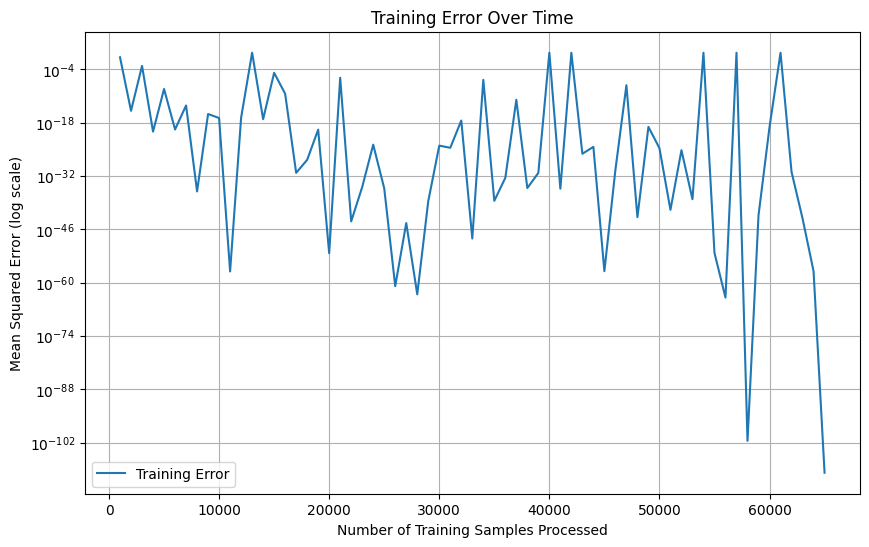

In [81]:
plt.figure(figsize=(10, 6))
plt.plot(steps, errors, label='Training Error')
plt.xlabel('Number of Training Samples Processed')
plt.ylabel('Mean Squared Error (log scale)')
plt.yscale('log')
plt.title('Training Error Over Time')
plt.legend()
plt.grid(True)
plt.show()

In [83]:
good_outcome = 0
bad_outcome = 0

for i in range(65000, len(X)):
    test = X[i].reshape(-1, 1)
    yt = np.zeros((10, 1))
    yt[y[i]] = 1

    out, _ = feedForward(test, 1)
    predicted_label = np.argmax(out)
    actual_label = y[i]

    if predicted_label == actual_label:
        good_outcome += 1
    else:
        bad_outcome += 1

accuracy = good_outcome / (good_outcome + bad_outcome) * 100
print(f"Accuracy: {accuracy:.2f}%")


Accuracy: 93.52%
